In [1]:
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.decomposition import PCA

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis import distances

import nglview as nv

import warnings
warnings.filterwarnings("ignore")

## 1. Introduction

The simulations in this tutorial are taken from: [M.T. Degiacomi (2019). Coupling Molecular Dynamics and Deep Learning to Mine Protein Conformational Space. Structure.](https://doi.org/10.1016/j.str.2019.03.018)

MurD is a 47-kDa ATP-driven ligase responsible for the biosynthesis of a bacterial peptidoglycan precursor (UDP-N-acetylmuramoyl-L-alanyl-D-glutamate). When bound to its ligand, UDP-N-acetylmuramoyl-L-alanyl-D-alanine, MurD is stabilized in a closed conformation (PDB: [3UAG](https://www.rcsb.org/structure/3UAG)).

In [5]:
folder = "data/MD_trajectories/" # this is the path where the three simulations are located

In [6]:
universe_closed = mda.Universe(f'{folder}MurD_closed.pdb')
w = nv.show_mdanalysis(universe_closed)
w

NGLWidget(max_frame=2506)

In the absence of UDP-N-acetylmuramoyl-L-alanyl-D-alanine, MurD takes instead an open conformation (PDB: [1E0D](https://www.rcsb.org/structure/1E0D)).

In [7]:
universe_open = mda.Universe(f'{folder}MurD_open.pdb')
w = nv.show_mdanalysis(universe_open)
w

NGLWidget(max_frame=1912)

By taking the closed conformation and manually removing the ligand, the protein switches to an open conformation.

In [8]:
universe_closed_apo = mda.Universe(f'{folder}MurD_closed_apo.pdb')
w = nv.show_mdanalysis(universe_closed_apo)
w

NGLWidget(max_frame=999)

Our objective in this exercises is to assign conformation of the latter simulation to either the closed or the open state.

## 2. Setup of feature extraction tools

The class `Featurizer` implements different ways of extracting features from a simulation using MDAnalysis. It is implemented to ensure consistency in feature extraction across the different datasets in the remainder of this exercises. Run this cell as-is.

In [12]:
class Featurizer(object):
    
    def __init__(self, feature):
        '''Featurizer class for extracting MD features with MDAnalysis
        Parameters:
        -----------
        feature : String
            name of feature
        '''
        if feature == "ramachandran":
            self.get_features = self._get_features_ramachandran
        elif feature == "distance matrix":    
            self.get_features = self._get_features_distance_matrix
        elif feature == "coordinates":    
            self.get_features = self._get_features_coordinates
        else:
            raise Exception("Features extraction method %s not recognised"%feature)
 
    def _get_features_distance_matrix(self, universe):
        '''
        distance matrix (lower diagonal)
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(distances.self_distance_array(ca.positions))

        return np.array(crds)
    
    def _get_features_coordinates(self, universe):
        '''
        alpha carbons coordinates
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(ca.positions.flatten())

        return np.array(crds)


    def _get_features_ramachandran(self, universe):
        '''
        dihedral angles
        '''
        pass
        #r = Ramachandran(universe.select_atoms('protein')).run()
        #return r.angles.reshape((r.angles.shape[0], np.prod(r.angles.shape[1:])))

The function `generate_train_test_sets` converts features extracted from different classes into training and test sets ready for classification (run the cell as-is).

In [13]:
def generate_train_test_sets(features, test_size=200, verbose=True):
    '''
    Assemble training and test set along with their labels.
    @param features list of two or more features array, each reporting features of a given class
    @param test_size dimension of the test set (number of examples to extract from each input features array)
    @param verbose if True, report on the number of examples contained in training and test set
    @return four arrays containing the training set and test set, followed by two arrays containing classification labels for training and test set.
    '''

    x_train_crds = []
    x_test_crds = []
    for i, crds in enumerate(features):

        #randomly separate features in training and test set
        indices = np.random.permutation(len(crds))
        indicestrain = np.sort(indices[test_size:])
        indicestest = np.sort(indices[:test_size])

        # build training set
        x_train = deepcopy(crds[indicestrain])
        x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
        x_train_crds.append(x_train) 

        # build test set
        x_test = deepcopy(crds[indicestest])
        x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))
        x_test_crds.append(x_test)

    # aggregate training and test set, and create classification for both
    train_set = np.concatenate(x_train_crds)
    test_set = np.concatenate(x_test_crds)
    train_class = np.concatenate((np.zeros(x_train_crds[0].shape[0]), np.ones(x_train_crds[1].shape[0])))
    test_class = np.concatenate((np.zeros(x_test_crds[0].shape[0]), np.ones(x_test_crds[1].shape[0])))

    if verbose:
        print(f'Training set: {train_set.shape[0]} examples')
        print(f'Test set: {test_set.shape[0]} examples')

    return train_set, test_set, train_class, test_class

## 3. Preparation and analysis of training set

We are now ready to collect features from two independent simulations of the closed and open state of MurD. 

In [14]:
# select a desired type of features
feature = "distance matrix"
F = Featurizer(feature) #maybe this could have a better name? something like dist_feat?

# extract features from the simulations of the closed state
feat_closed = F.get_features(universe_closed)
print(f'closed state: {feat_closed.shape[0]} conformations, {feat_closed.shape[1]} features')

# extract features from the simulation of the open state
feat_open = F.get_features(universe_open)
print(f'open state: {feat_open.shape[0]} conformations, {feat_open.shape[1]} features')

closed state: 2507 conformations, 95266 features
open state: 1913 conformations, 95266 features


Let's now convert the features we just extracted in datasets ready for classification. The datasets are combined and randomly split into training and test sets.

In [15]:
train_set, test_set, train_class, test_class = generate_train_test_sets([feat_closed, feat_open])

Training set: 4020 examples
Test set: 400 examples


Before going further, it is a good idea to take look at the training data we have just produced by projecting it on a lower dimensional space using Principal Components Analysis (PCA), c.f. dimensionality reduction from yesterday.

In [16]:
pca = PCA(n_components=2)
pca.fit(train_set)
proj_closed = pca.transform(feat_closed)
proj_open = pca.transform(feat_open)

Now, let's plot a projection of the data in 2D space, also reporting the percentage of variance represented by each component.

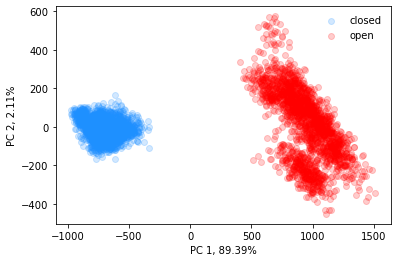

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.2, color="dodgerblue", label="closed")
ax.scatter(proj_open[:, 0], proj_open[:, 1], alpha=0.2, color="red", label="open")
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')
ax.legend(frameon=False)

<div class="alert alert-success">
<b>Task 1.</b> Discuss: Do PC1 and PC2 give you well-separated clusters? What does this tell us about the features we extracted? Do you need more dimensions to obtain a better separation?</div>

<details>
<summary> <mark> Answer 1</mark> </summary>
If the open and closed state are well-separated in the 2D projection, this means that the features selected are highly correlated.
</details>

## 4. Training a Random Forests classifier on input data

Let's start by training the classifier using the training set we have just assembled

In [18]:
# I would link here to scikitlearn and maybe only do the import here and talk about how we use scikit learn
RF = RandomForestClassifier(n_estimators=50)
RF.fit(train_set, train_class)

RandomForestClassifier(n_estimators=50)

Let's now assess its performance against the test set.

In [19]:
r = RF.predict(test_set)
success = np.sum((r-test_class)==0)
percent = float(success)/len(test_class)*100
print(f'Success of test set: {percent}%')

Success of test set: 100.0%


To see which features are deemed the most useful for a successful classification, we can observe their importance.

In [23]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

if feature == "distance matrix": 
    
    # get indices of most important CA atoms pair
    na = len(universe_closed.select_atoms('name CA'))
    pos = np.array(np.triu_indices(na))[:, np.argmax(std)].T
    
    # retrieve their identity
    ca1 = universe_closed.select_atoms('name CA')[pos[0]]
    ca2 = universe_closed.select_atoms('name CA')[pos[1]]
    print(f'Most relevant distance: {ca1.resname}{ca1.resid} - {ca2.resname}{ca2.resid}')
    

elif feature == "coordinates":
    
    ca = universe_closed.select_atoms('name CA')[int(np.argmax(std)/3)]
    print(f'Most relevant amino acid: {ca.resname}{ca.resid}')

Most relevant distance: GLN4 - ASP372


In [ ]:
## Maybe you could have an additional taks here, such as what if you change the number of estimators?
## I think some more explanation above would be good. At what point do you need feature == coordinate

<div class="alert alert-success">
<b>Task 2.</b> Run section 4 again from the beginning. Is the most relevant feature always the same? Why?</div>

<details>
<summary> <mark> Answer 2</mark> </summary>
Training the Random Forests classifier again will give different results because the training process is stochastic, and thus it will converge to different models. Their performance will be likely comparable, because there normally exist multiple models  performing equally comparatively well in a classification task.</details>

## 5. Classification of conformations from new simulation

It is now time to characterize the simulation of a trajectory switching to the closed to the open state.

In [20]:
feat = F.get_features(universe_closed_apo) # maybe better name here too?
r = RF.predict(feat)

Let's have a look at the classification. This can be done with a simple colorbar, where different colours represent different classes.

Text(0.5, 0, 'conformation / #')

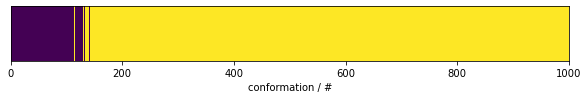

In [21]:
fig = plt.figure(1, figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh([r])
ax.set_yticks([])
ax.set_xlabel("conformation / #")

Let's compare the three datasets (closed, open, and open apo) according to the value most important feature according to the classifier.

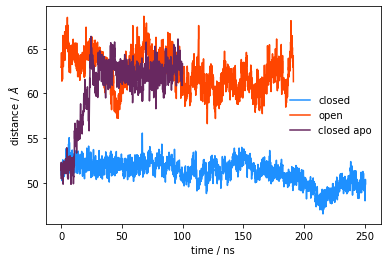

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(len(feat_closed))/10., feat_closed[:, np.argmax(std)], label="closed", color="dodgerblue")
ax.plot(np.arange(len(feat_open))/10., feat_open[:, np.argmax(std)], label="open", color="orangered")
ax.plot(np.arange(len(feat))/10., feat[:, np.argmax(std)], label="closed apo", color="#682860")

ax.set_xlabel("time / ns")
ax.set_ylabel("distance / $\AA$")
ax.legend(frameon=False)

The closed apo simulation appears to take values in its most important feature different from anything seen in the training set. Here we will carry out an outlied detection using an Isolation Forest. More information about outlier detection is available [here](https://scikit-learn.org/stable/modules/outlier_detection.html). The following cell may take some time to run (a few minutes).

In [25]:
clf = IsolationForest(n_estimators=50, warm_start=True)
clf.fit(train_set)

y_closed_apo = clf.predict(feat)

Text(0.5, 0, 'conformation / #')

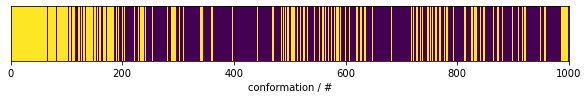

In [26]:
fig = plt.figure(1, figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh([y_closed_apo])
ax.set_yticks([])
ax.set_xlabel("conformation / #")

<div class="alert alert-success">
<b>Task 3.</b> There seem to be quite a few outliers, what does this tell us about the closed apo simulation?</div>

<details>
<summary> <mark> Answer 3</mark> </summary>
The classification we obtained tells us that the second part of the simulation is more similar to the open than the closed state, however its conformations are not consistent with those sampled by the open simulations.</details>

Let's observe how the most relevant feature measured in the closed apo simulation relates to that of closed and open simulations in the eigenspace of the PCA projection.

Text(0, 0.5, 'PC 2, 2.11%')

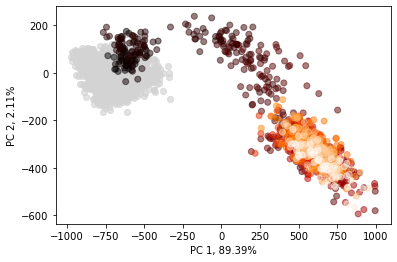

In [27]:
proj_closed_apo = pca.transform(feat)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.4, c="lightgrey")
ax.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.4, c="lightgrey")
ax.scatter(proj_closed_apo[:, 0], proj_closed_apo[:, 1], alpha=0.5, c=np.arange(len(proj_closed_apo)), cmap="gist_heat") 
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')

<div class="alert alert-success">
<b>Task 4.</b> In section 2 we have defined the class <code>Featurizer</code>, defining different methods to extract features from an MDAnalysis Universe. The class was used in the first cell of section 3. Run again this notebook using the keyword "coordinates". What do you notice? Can you think about a disadvantage of using coordinates?</div>

<details>
<summary> <mark> Answer 4</mark> </summary>
Using coordinates also leads to good results. The main differences from what observed using distance matrix are:
<ul>
<li>Coordinates constitude a smaller set of features than distance matrix. This leads to faster runtimes.</li>
<li>the pattern followed by outliers is different. When using distance matrix, they become abundant as soon as the protein leaves the closed state, while when using coordinates they are most abundant when the protein is in-between the two states.
</li>
<li>a disadvantage of using coordinates is that, unlike distance matrix, results will depend on how the simulations are aligned. Different alignments would lead to different results. If the trajectories were not aligned at all, using absolute coordinates would not work.</li>

</ul>
</details>

<div class="alert alert-success">
<b>Task 4.</b> Return to section 2 and, within the class <code>Featurizer</code>, implement the method <code>_get_features_ramachandranan</code>, returning a list of phi and psi angles (backbone dihedrals). Rerun the rest of the notebook with your new feature.</div>

<details>
<summary> <mark> Answer 5</mark> </summary>
    
```Python
def _get_features_ramachandran(self, universe):
    r = Ramachandran(universe.select_atoms('protein')).run()
    return r.angles.reshape((r.angles.shape[0], np.prod(r.angles.shape[1:])))
```
</details>
